# Exploratory Data Analysis (EDA)

In this file we do an exploratory data analysis on the training data set.

## 1. Waiver Prediction Models

We began with the tentative question: can we predict whether or not a player will be waived, given past statistics and salary data?

The cells below we:
- load the data
- scale the data within a given season
- find correlations between predictors and whether or not a player was waived in the next season
- compute statistical significance for predictors which vary noticeably between waived and non-waived players
- train a series of classifiers to predict whether or not a given player will be waived.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
player_data = pd.read_csv("train_data.csv")

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
class YearWiseStandardScaler(BaseEstimator,TransformerMixin):
    def __init__(self, year_column):
        self.year_column = year_column
        self.year_stats = {}
    def fit(self, X, y = None):
        grouped = X.groupby(self.year_column)
        for year, group in grouped:
            self.year_stats[year] = {
                "mean": group.mean(),
                "std": group.std(ddof=0), 
            }
        return self
    def transform(self, X):
        def scale_row(row):
            year = row[self.year_column]
            stats = self.year_stats[year]
            return (row - stats["mean"]) / stats["std"]

        scaled_data = X.apply(scale_row, axis=1)
        scaled_data = scaled_data.drop(columns=self.year_column)
        
        return scaled_data

In [4]:
#Checking that my YearWiseStandardScaler works
toy_data = {
    "Feature1": [1.5, 1.0, 2.4, 0.0, 8.1, 9.2],
    "Feature2": [10, 20, 30, 40, 50, 60],
    "Year": [2023, 2022, 2022, 2023, 2019, 2022]
}

toy_df = df = pd.DataFrame(toy_data)

scaler = YearWiseStandardScaler(year_column ="Year")
scaler.fit(toy_df)
scaled_df = scaler.transform(toy_df)
print(scaled_df)

   Feature1  Feature2
0  1.000000 -1.000000
1 -0.893497 -0.980581
2 -0.502592 -0.392232
3 -1.000000  1.000000
4       NaN       NaN
5  1.396089  1.372813


In [5]:
len(player_data)
player_data['WAIVED_BY_START_OF_NEXT_SEASON'] = player_data[['WAIVED', 'RELEASED']].any(axis=1).astype(int)
player_data.sample()

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,...,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,IN_LEAGUE_NEXT,WAIVED_BY_START_OF_NEXT_SEASON
2811,Kevin Garnett,708,1995,['MIN'],20.0,1.0,SF,80.0,43.0,2293.0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
player_data = player_data.dropna(subset=['SALARY'])
len(player_data)

player_data = player_data[player_data['MIN'] != 0]
len(player_data)

11394

In [7]:
columns_to_normalize = ['FGM', 'FGA', 'PTS', 'PF', 'DREB', 'OREB', 'REB', 'FTA', 'FTM', 'STL', 'TOV', 'BLK', 'AST', 'FG3A', 'FG3M']

# Normalize the selected columns by dividing by 'MIN'
player_data[columns_to_normalize] = player_data[columns_to_normalize].div(player_data['MIN'], axis=0)

# Rename columns to include "per minute"
rename_dict = {col: f"{col} / MIN" for col in columns_to_normalize}
player_data.rename(columns=rename_dict, inplace=True)

player_data.sample()

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,...,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,IN_LEAGUE_NEXT,WAIVED_BY_START_OF_NEXT_SEASON
4789,Kevin Ollie,1563,1997,"['DAL', 'ORL']",25.0,1.0,PG,35.0,0.0,430.0,...,1,0,0,0,0,0,0,0,1,1


Now let's find the most correlated features

In [8]:
numeric_data = player_data.select_dtypes(include=['number'])

correlations = numeric_data.corr()['WAIVED_BY_START_OF_NEXT_SEASON']
sorted_correlations = correlations.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Print the sorted correlations
print(sorted_correlations)

# Reset display options if needed
pd.reset_option('display.max_rows')

WAIVED_BY_START_OF_NEXT_SEASON    1.000000
WAIVED                            0.947449
WAIVED_REG                        0.795938
WAIVED_OFF                        0.571506
RELEASED                          0.325645
RELEASED_OFF                      0.295017
RELEASED_REG                      0.131331
PF / MIN                          0.106916
TOV_PERCENT                       0.106464
WAIVED_POST                       0.089167
PLAYER_AGE                        0.080225
RELEASED_POST                     0.063034
X3P_AR                            0.055353
PLAYER_ID                         0.034326
SEASON_START                      0.024243
TOV / MIN                         0.023506
TRADED_REG                        0.023022
FG3A / MIN                        0.020922
TRADED                            0.006751
EXPERIENCE                        0.005129
OREB / MIN                       -0.006836
STL_PERCENT                      -0.006875
F_TR                             -0.007385
STL / MIN  

Since player_ID is correlated at 10% despite being complete random, let's take anything that's correlated at 15% or higher

In [9]:
Xfeatures = ['GP', 'MIN', 'DWS', 'GS', 'WS', 'OBPM', 'BPM', 'PER', 'OWS', 'WS_48', 'FT_PCT', 'FG_PCT', 'FGM / MIN', 'PTS / MIN', 'VORP', 'TS_PERCENT', 'SALARY', 'FTM / MIN', 'USG_PERCENT', 'FTA / MIN', 'FGA / MIN' , 'SEASON_START']
len(Xfeatures)

22

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_player_data, test_player_data = train_test_split(player_data, test_size=0.2, stratify=player_data['WAIVED_BY_START_OF_NEXT_SEASON'], random_state=812)
print(len(train_player_data))
print(len(test_player_data))

9115
2279


In [12]:
train_player_data_waived = train_player_data.loc[train_player_data['WAIVED_BY_START_OF_NEXT_SEASON'] == 1]
train_player_data_unwaived = train_player_data.loc[train_player_data['WAIVED_BY_START_OF_NEXT_SEASON'] == 0]
p = len(train_player_data_waived)/len(train_player_data)
print(p)
print(p*(1 - p))
bbs = p*(1 - p)

0.11705979155238617
0.10335679675409806


About 11% of the players are waived, which is useful to have as a baseline for the various metrics. For instance, baseline accuracy would be p^2 + (1 - p)^2 which is about .8042.

We next look at some individual stats to determine what if there are statistically significant differences in the aggregate between the two classes of players. For example, in Field Goal percentage we get the following two charts:

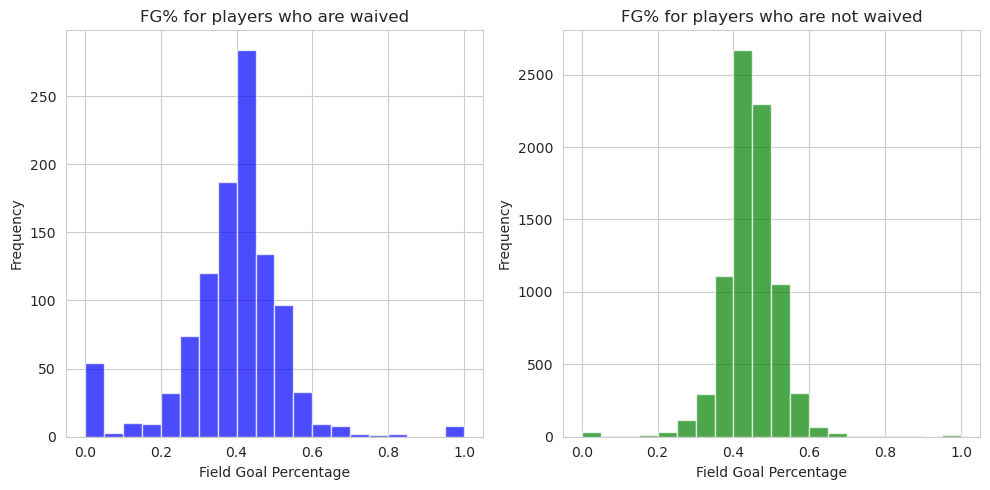

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_player_data_waived['FG_PCT'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('FG% for players who are waived')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_player_data_unwaived['FG_PCT'].dropna(), bins=20, color='green', alpha=0.7)
plt.title('FG% for players who are not waived')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
train_player_data_waived.loc[:, 'FG_PCT'].mean()

0.38967197750702903

In [15]:
train_player_data_unwaived.loc[:, 'FG_PCT'].mean()

0.4449635934393638

On the whole, this difference is highly statically significant. The p-value for a sample of unwaived players to have a FG% as low as unwaived players on average is extremely small.

In [16]:
from scipy import stats
unstandardizedZ = train_player_data_waived.loc[:,'FG_PCT'].mean()
mu = train_player_data_unwaived.loc[:, 'FG_PCT'].mean()
sigma = train_player_data_unwaived.loc[:, 'FG_PCT'].std()
size = len(train_player_data_waived)
standardizedZ = (size*unstandardizedZ - mu*size)/(np.sqrt(size)*sigma)
p_value = stats.norm.cdf(standardizedZ)
print(standardizedZ)
print(p_value)

-24.197331077533356
1.1867041057329942e-129


If there is more EDA stuff to add it should be added here.

Now we try some models to see how well the stats can predict at <i>an individual level</i> if a player will be waived or traded. We'll look at KNN classification, logistic classification, decision trees, and random forest classifiers. The metrics we are interested in are f1_score, accuracy_score, balanced_accuracy_score, and the brier score (with predict proba). Given the 11/89 split of waived and unwaived, the baseline metrics to compare to with a random guess that guesses a player will be waived with probability 11 would have metrics:

Accuracy: 0.7952 <br>
Balanced Accuracy: 0.5000 <br>
F1-Score: 0.1158 <br>
1 - Brier Score: 0.8976 <br>(Subtracting from 1 since a <i> smaller </i> Brier score is better.)

These are what we should compare our metrics against.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, brier_score_loss, balanced_accuracy_score

In [18]:
train_player_data = train_player_data.dropna(subset = Xfeatures)
print(len(train_player_data))
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=812, stratify = y)
knn_pipeline = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column = 'SEASON_START')),
    ('knn', KNeighborsClassifier(n_neighbors = 15))
])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Baseline F1 score: ", p)
print("Baseline Balanced Accuracy: .5")
print("Baseline Accuracy: ", p**2+(1 - p)**2)

9099
F1 score:  0.1984732824427481
Balanced Accuracy:  0.5538425739103797
Accuracy:  0.8846153846153846
Baseline F1 score:  0.11705979155238617
Baseline Balanced Accuracy: .5
Baseline Accuracy:  0.7932864064918037


In [19]:
y_prob = knn_pipeline.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)
print("Baseline Brier Score: ", bbs)

Brier Score:  0.08761416361416362
Brier Skill Score:  0.1523134775295777
Baseline Brier Score:  0.10335679675409806


In [20]:
metric_summary  = {
    "Metric": ["Accuracy", "Balanced Accuracy", "F1 Score", "1-Brier Score"],
    "KNN Model": [0.8846, 0.5538, 0.1985, 1-0.0876],
    "Baseline": [0.7952, 0.5000, 0.1158, 1-0.1024],
}

# Create a DataFrame
metrics_df = pd.DataFrame(metric_summary)
metrics_df

,Metric,KNN Model,Baseline
0,Accuracy,0.8846,0.7952
1,Balanced Accuracy,0.5538,0.5000
2,F1 Score,0.1985,0.1158
3,1-Brier Score,0.9124,0.8976


In [23]:
from sklearn.linear_model import LogisticRegression
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=813, stratify = y)

In [24]:
log_reg = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column = 'SEASON_START')),
    ('logreg', LogisticRegression(max_iter=10000))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.22302158273381295
Balanced Accuracy:  0.5622726429238378


In [25]:
y_prob = log_reg.predict_proba(X_test)

In [26]:
y_prob
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.08383540826009821
Brier Skill Score:  0.18887377615276024


In [27]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [28]:
#tree_cfr = Pipeline([(scaler = YearWiseStandardScaler(year_column = 'SEASON_START'), (classifier = DecisionTreeClassifier(max_depth=6, random_state=814)))])
tree_cfr = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column='SEASON_START')),  
    ('classifier', DecisionTreeClassifier(max_depth = 6, random_state=814))  
])
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=815, stratify = y)
tree_cfr.fit(X_train, y_train)
y_pred = tree_cfr.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.2827586206896552
Balanced Accuracy:  0.5853478213485165


In [29]:
y_prob = tree_cfr.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.09570581321800904
Brier Skill Score:  0.07402496764960609


In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 50, 
    max_depth = 3, 
    max_features = 6, 
    bootstrap= True, 
    max_samples = 500,
    random_state = 816
    )
rf = Pipeline([('scaler', YearWiseStandardScaler(year_column='SEASON_START')), ('classifier', RandomForestClassifier(
    n_estimators = 50, 
    max_depth = 3, 
    max_features = 6, 
    bootstrap= True, 
    max_samples = 500,
    random_state = 816
    ))])

In [31]:
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=817, stratify = y)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.14937759336099585
Balanced Accuracy:  0.5389250041973614


In [32]:
y_prob = tree_cfr.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.07267239531529213
Brier Skill Score:  0.2968784095719308


Of the non-ensemble methods, the decision tree works best, so let's boost that one with AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                                n_estimators=100,
                                algorithm = 'SAMME',
                                learning_rate = 0.05,
                                random_state=818)
ada_clf = Pipeline([('scalar', YearWiseStandardScaler(year_column = 'SEASON_START')), ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                                n_estimators=100,
                                algorithm = 'SAMME',
                                learning_rate = 0.05,
                                random_state=818))])

In [35]:
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=817, stratify = y)
ada_clf.fit(X_train, y_train)

Pipeline(steps=[('scalar', YearWiseStandardScaler(year_column='SEASON_START')),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=6),
                                    learning_rate=0.05, n_estimators=100,
                                    random_state=818))])

In [36]:
y_pred = tree_cfr.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.4261168384879725
Balanced Accuracy:  0.6413258949216345


In [37]:
y_prob = ada_clf.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.0906774177083412
Brier Skill Score:  0.12267581275688222


## 2. Looking for stronger correlations

It appears to be very hard to predict whether or not a player will be waived based on the data we have. Instead we will consider other potential response variables related to player transactions and movement.

In the cells below we:
- compute the correlations with all numeric columns
- print numeric values for correlations with largest magnitudes.

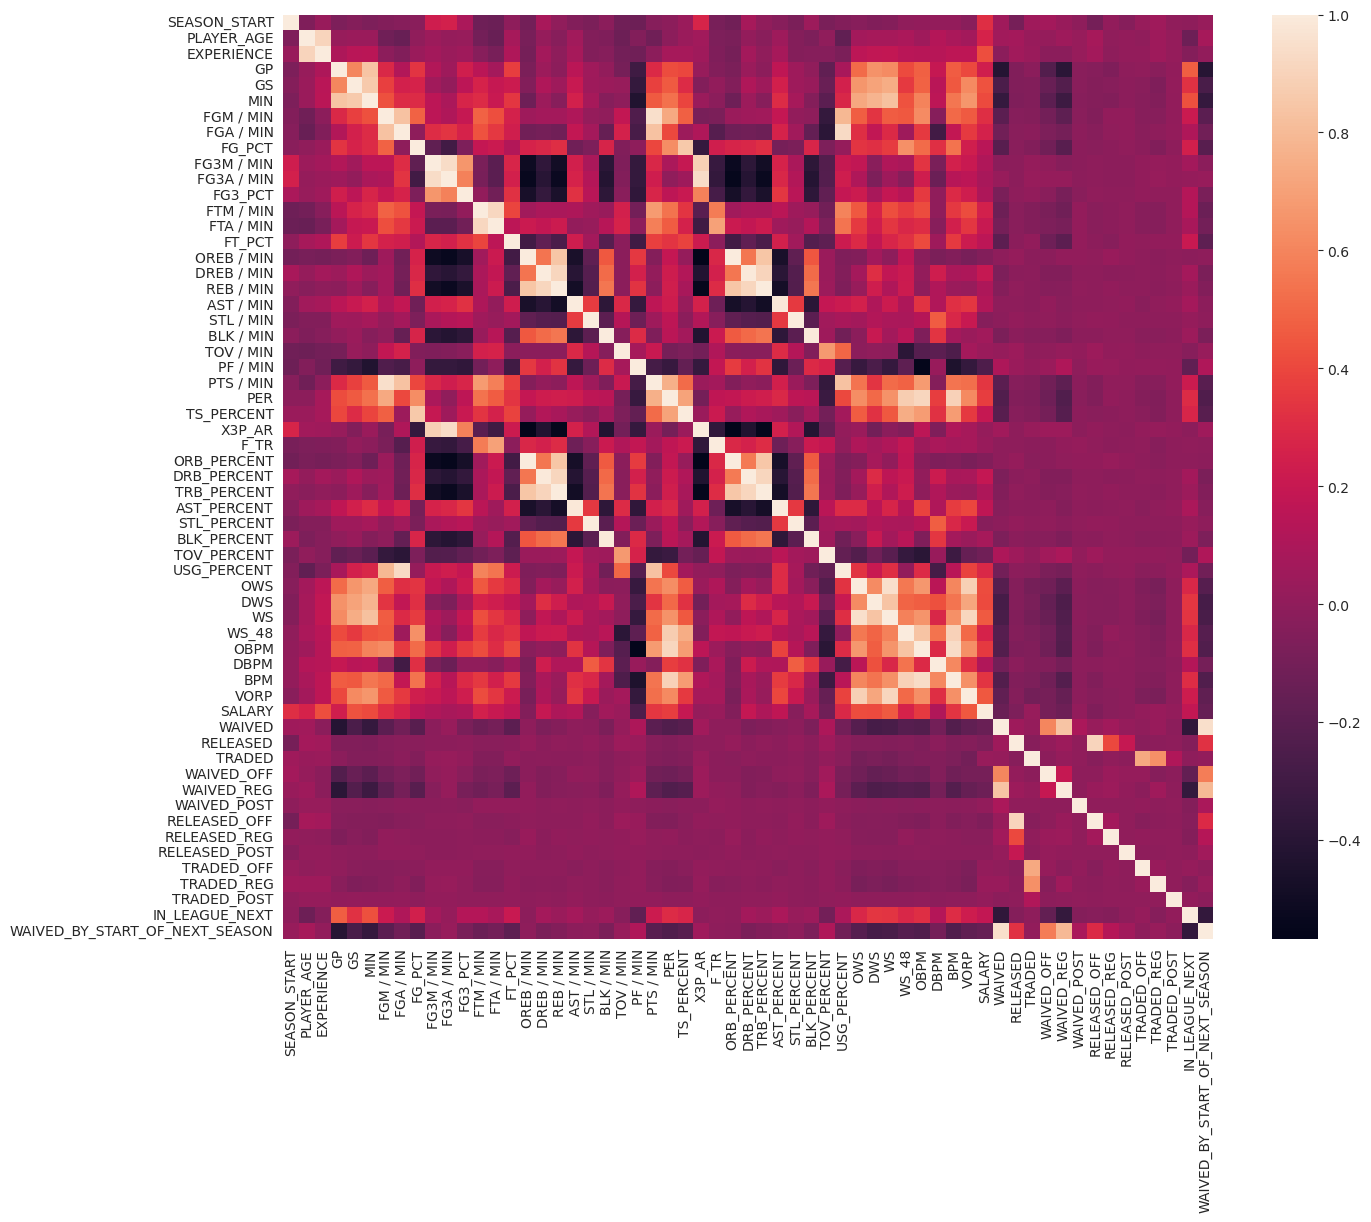

In [38]:
# grab all columns
all_cols = list(player_data.columns)

# grab just the columns with numeric data
num_cols = player_data.select_dtypes(include='number').columns.drop('PLAYER_ID')

# compute correlations between numeric data columns
corr = player_data[num_cols].corr()

# plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

We can see that correlations between statistics and `IN_LEAGUE_NEXT` (whether or not a given player will be in the NBA in the following season) appear to be fairly large.  Let's print the correlations with the largest magnitudes.

In [39]:
# print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
print(abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15])

IN_LEAGUE_NEXT                    1.000000
GP                                0.468935
MIN                               0.427268
WAIVED                            0.368301
WAIVED_BY_START_OF_NEXT_SEASON    0.356754
WAIVED_REG                        0.351514
DWS                               0.341351
WS                                0.333532
GS                                0.321839
OBPM                              0.309042
BPM                               0.302171
PER                               0.296856
OWS                               0.280260
WS_48                             0.279315
TS_PERCENT                        0.273968
Name: IN_LEAGUE_NEXT, dtype: float64


We can see that correlations with `IN_LEAGUE_NEXT` get close in magnitude to 0.5.  This is promising, and in the next notebook (`3_ModelSelection.ipynb`) we use this variable as our response variable.

### Summary

Our initial question involved trying to predict NBA player transactions (specifically, if a given player would be waived).  It turned out that the statistics we have are too weakly correlated to waivers in order for us to answer this question with any real confidence.

Instead, we will consider `IN_LEAGUE_NEXT` (whether or not a given player will still be in the NBA next season) as our new response variable.  Our central question is then: can we predict whether or not a given player will be _retained in the NBA next season_ given their past/current statistics, salary, and transaction data?

We construct and select models to answer this question in the notebook `3_ModelSelection.ipynb`.